Python port of COVID mortality analysis originally done in R.

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
import matplotlib as mpl
import time
import datetime as dt

Set global settings for libraries

In [2]:
sb.set_style(style="ticks")
mpl.rcParams['axes.formatter.use_locale'] = True

Load required data.

In [3]:
calendar = pd.read_csv('Calendar.csv', 
                       encoding='utf-8', 
                       parse_dates=['Date'])

calendar['Week Starting'] = \
    pd.to_datetime(calendar['Week Starting'], 
                   format='%Y-%m-%d', 
                   errors='coerce')

mortality_by_age_sex_week = \
    pd.read_csv('Provisional_COVID-19_Deaths_by_Week__Sex__and_Age.csv', \
                encoding='utf-8', \
                parse_dates=['End Week'])

Set up global data

In [4]:
age_group_infants_toddlers = ['Under 1 year','1-4 Years']
age_group_adolescents = ['5-14 Years','15-24 Years']
age_group_seniors = ['55-64 Years',
                     '65-74 Years',
                     '75-84 Years',
                     '85 Years and Over']

mortality_df = mortality_by_age_sex_week.merge(calendar, \
                                               left_on="End Week", \
                                               right_on="Date")
    
mortality_df = mortality_df[(mortality_df['Age Group'] != 'All Ages') & 
                            (mortality_df['Sex'] == 'All Sex')]

mortality_df['Age Group Category'] = "3. Adults (25-54)"

mortality_df.loc[mortality_df['Age Group'].isin(age_group_infants_toddlers), 
                 ['Age Group Category']] = "1. Infants/Toddlers (<5)"
mortality_df.loc[mortality_df['Age Group'].isin(age_group_adolescents), 
                 ['Age Group Category']] = "2. Adolescents/YA (5-24)"
mortality_df.loc[mortality_df['Age Group'].isin(age_group_seniors) , 
                 ['Age Group Category']] = "4. Seniors (55+)"


Generate stats by high-level age category and ratios comparing against total 
COVID and all-cause deaths for the given weekly time range.

In [5]:
mortality_df_weekly_total = mortality_df.groupby(
    by='Week Starting'
    ).aggregate({'COVID-19 Deaths':'sum',
                 'Total Deaths': 'sum'})
mortality_df_weekly_total = mortality_df_weekly_total.rename(columns={
    'COVID-19 Deaths': 'total_covid_deaths_for_week',
    'Total Deaths': 'total_deaths_for_week'
    })

mortality_df = mortality_df.join(mortality_df_weekly_total)

mortality_df_weekly_total_age_group_category = mortality_df.groupby(
    by=['Age Group Category', 'Week Starting']
    ).aggregate({'COVID-19 Deaths': 'sum',
                 'Total Deaths': 'sum'})

mortality_df_weekly_total_age_group_category['total_all_non_covid_deaths_by_agc'] = \
    mortality_df_weekly_total_age_group_category['Total Deaths'] \
    - mortality_df_weekly_total_age_group_category['COVID-19 Deaths']
    
mortality_df_weekly_total_age_group_category = \
    mortality_df_weekly_total_age_group_category.rename(
        columns={'COVID-19 Deaths': 'total_covid_deaths_by_agc',
                 'Total Deaths': 'total_all_cause_deaths_by_agc'})
    
mortality_df_yearly_total_age_group_category = mortality_df.groupby(
    by=['Age Group Category', 'Year']
    ).aggregate({'COVID-19 Deaths': 'sum',
                 'Total Deaths': 'sum'})
                 
mortality_df_yearly_total_age_group_category = \
    mortality_df_yearly_total_age_group_category.rename(
        columns={'COVID-19 Deaths': 'total_covid_deaths_by_agc',
                 'Total Deaths': 'total_all_cause_deaths_by_agc',
                 'Age Group Category': 'agc'})

mortality_df_yearly_total_age_group_category = \
    mortality_df_yearly_total_age_group_category.reset_index()

mortality_summary_df = \
    mortality_df_weekly_total_age_group_category.join(mortality_df_weekly_total)
mortality_summary_df['covid_all_deaths_ratio'] = \
    mortality_summary_df['total_covid_deaths_by_agc'] / mortality_summary_df['total_all_cause_deaths_by_agc']

mortality_summary_df['covid_all_deaths_pct'] = \
    mortality_summary_df['covid_all_deaths_ratio'] * 100
    
mortality_summary_df['covid_deaths_ratio'] = \
    mortality_summary_df['total_covid_deaths_by_agc'] / mortality_summary_df['total_covid_deaths_for_week']
mortality_summary_df['covid_deaths_pct'] = \
    mortality_summary_df['covid_deaths_ratio'] * 100


Filter out insignificant categories (if desired)

In [6]:
df_filtered = mortality_summary_df 

Let's look at deaths per week by age group category. Notice very high senior 
(55+) mortality compared to other groups.

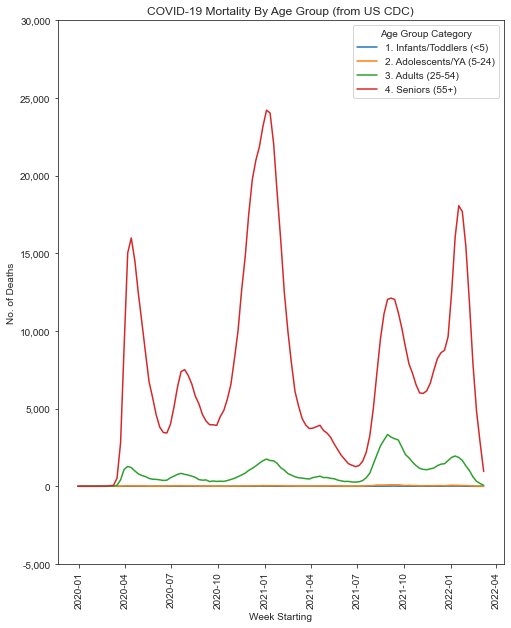

In [7]:
f, ax = plt.subplots(figsize=(8,10))

p = sb.lineplot(
        data=df_filtered,
        x='Week Starting',
        y="total_covid_deaths_by_agc",
        hue='Age Group Category',
        legend=True
    ).set(
        title="COVID-19 Mortality By Age Group (from US CDC)",
        ylabel="No. of Deaths"
    )

axis = plt.gca()
current_values = axis.get_yticks().tolist()
axis.set_yticks(current_values)
axis.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.xticks(rotation=90)

plt.show(p)

Looking at same as previous chart but using a logarithmic scale to see changes in relatively unaffected age groups. You can see clearly that adult and senior age groups are 3-4 orders of magnitude higher risk than the child and teenage age groups.

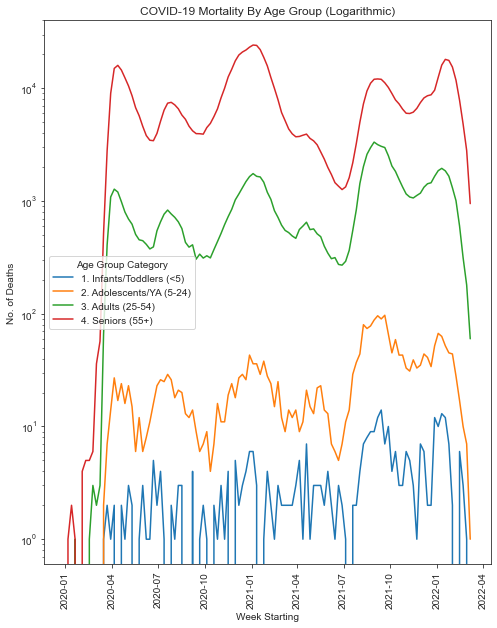

In [8]:
f, ax = plt.subplots(figsize=(8,10))

p = sb.lineplot(
        data=df_filtered,
        x='Week Starting',
        y="total_covid_deaths_by_agc",
        hue='Age Group Category',
        legend=True
    ).set(
        title="COVID-19 Mortality By Age Group (Logarithmic)",
        ylabel="No. of Deaths"
    )

plt.xticks(rotation=90)
plt.yscale('log')
                    
plt.show(p)

Looking at the annual numbers, it is crystal clear that Under 24's are under almost negligible fatality risk from COVID.

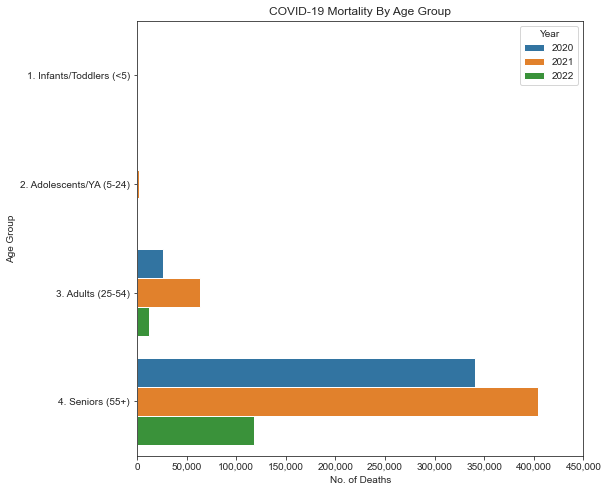

In [9]:
f, ax = plt.subplots(figsize=(8,8))

p = sb.barplot(
        data=mortality_df_yearly_total_age_group_category,
        x="total_covid_deaths_by_agc",
        y="Age Group Category",
        hue="Year"
    ).set(
        title="COVID-19 Mortality By Age Group",
        xlabel="No. of Deaths",
        ylabel="Age Group"
    )

axis = plt.gca()
current_values = axis.get_xticks().tolist()
axis.set_xticks(current_values)
axis.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.show(p)